In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
### Loading dataset
### --------------------

df = pd.read_csv("./data/german_credit_dataset.csv").drop('Sno', axis = 1)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


### Context
Each entry represents a person taking a credit from a bank. Based on a set of attributes, each person is classified as a good or bad credit risk.

### Content
Due to the complex system of categories and symbols, understanding the original dataset can be challenging. Therefore, I created a Python script to convert it into a more readable CSV format. Several columns were excluded because they seemed either irrelevant or too obscure. The selected attributes are as follows:

- **Age** (numeric)
- **Sex** (text: male, female)
- **Job** (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- **Housing** (text: own, rent, or free)
- **Saving accounts** (text: little, moderate, quite rich, rich)
- **Checking account** (numeric, in DM - Deutsch Mark)
- **Credit amount** (numeric, in DM)
- **Duration** (numeric, in months)
- **Purpose** (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

<Axes: xlabel='Age', ylabel='Credit amount'>

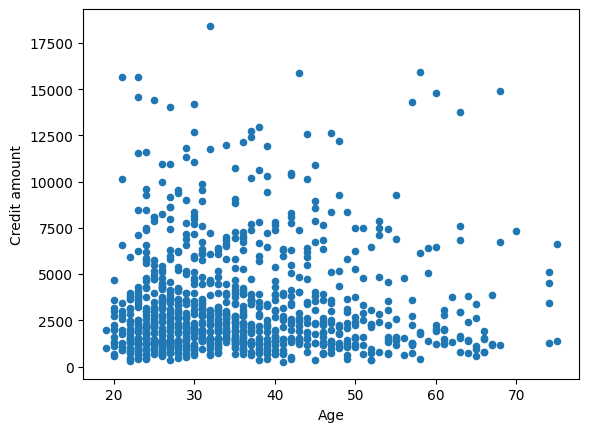

In [3]:
### Plotting data
### --------------------

df.plot(kind='scatter', x='Age', y='Credit amount')

array([<Axes: title={'center': 'bad'}>, <Axes: title={'center': 'good'}>],
      dtype=object)

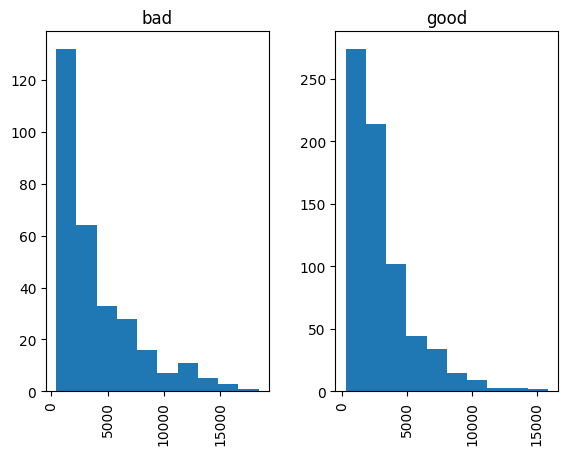

In [4]:
df.hist(column = 'Credit amount', by = 'Risk')

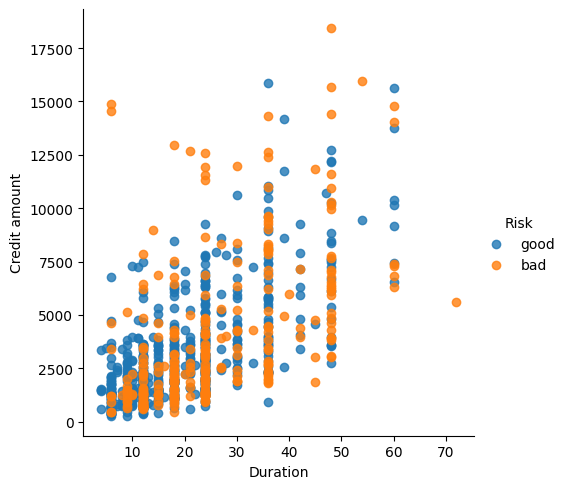

In [5]:
sns.lmplot(x='Duration', y='Credit amount', hue = 'Risk', data = df, fit_reg = False)

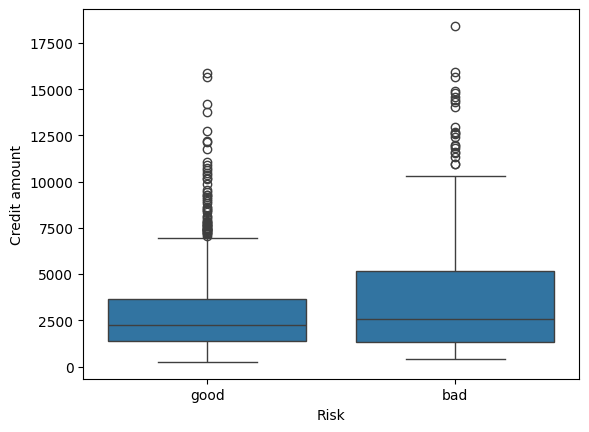

In [6]:
sns.boxplot(x = 'Risk', y = 'Credit amount', data = df)
plt.show()

In [5]:
### train ML model
### --------------------

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [6]:
y_raw = df['Risk']
X_raw = df.drop('Risk', axis=1)

In [7]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [8]:
### sklearn pipeline
### --------------------

categorical_features = X_raw.select_dtypes(include=['object']).columns
numeric_features = X_raw.select_dtypes(include=['int64', 'float']).columns

# Imputer will string "missing" for every missing value
# Encoder will convert each category into a binary 0 or 1
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
    ('onehotencoder', OneHotEncoder(categories='auto', sparse=False))])

# Scaler will convert all numerical features so that they have a mean of 0
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

feature_engineering_pipeline = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ], remainder="drop")

# Encode Labels
le = LabelEncoder()
encoded_y = le.fit_transform(y_raw)

# Create sklearn pipeline
lr_clf = Pipeline(steps=[('preprocessor', feature_engineering_pipeline),
                         ('classifier', LogisticRegression(solver="lbfgs"))])

In [9]:

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_raw, encoded_y, test_size=0.20, stratify=encoded_y, random_state=42)

In [10]:
### fit model
### --------------------

lr_clf.fit(X_train, y_train)

c:\Users\sifinell\OneDrive\HSG\MLOps\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object'))])),
                ('classifier', LogisticRegression())])

Accuracy on test data set:  0.735
Recall for class 'Bad':    0.45


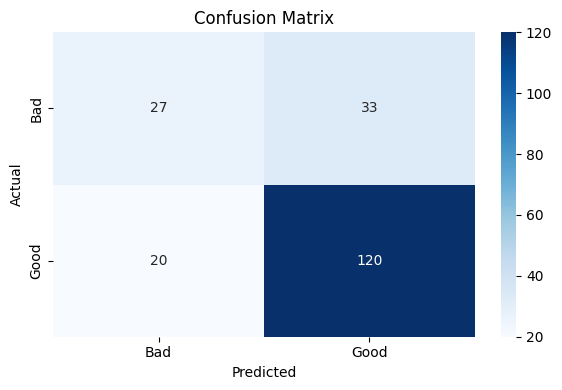

Classification Report:
              precision    recall  f1-score   support

         Bad       0.57      0.45      0.50        60
        Good       0.78      0.86      0.82       140

    accuracy                           0.73       200
   macro avg       0.68      0.65      0.66       200
weighted avg       0.72      0.73      0.72       200



In [11]:
### evaluate model
### --------------------

from sklearn.metrics import recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy and recall
print("Accuracy on test data set: ", lr_clf.score(X_test, y_test))
print("Recall for class 'Bad':   ", recall_score(y_test, lr_clf.predict(X_test), pos_label=0))

# Confusion Matrix
y_pred = lr_clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Plot confusion matrix as an image
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=["Bad", "Good"])
print("Classification Report:")
print(class_report)

In [12]:
### persisting model
### --------------------

joblib.dump(value=lr_clf, filename='model.pkl')

['model.pkl']

In [13]:
### making 5 predictions
### --------------------

new_data = df[:5]
new_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [14]:
lr_clf.predict(new_data)

array([1, 0, 1, 0, 1])